# Das Bias-Varianz-Dilemma

Mit der Aufteilung der Daten in Test- und Trainingsdaten können wir untersuchen,
ob ein Modell prinzipiell die Trainingsdaten gut erklärt. Wie gut es neue Daten
prognostizieren kann, d.h. wie gut es verallgemeinert, beurteilen wir mit den
Testdaten. Was ist aber, wenn wir mit dem gewählten Modell nicht zufrieden sind
und mit anderen Modellen vergleichen wollen? Nicht nur die Modellauswahl selbst
ist schwierig. Jedes Modell hat selbst noch Finetuning-Optionen. Die Parameter,
die zu einem Modell gehören und nichts mit den Daten zu tun haben, werden
**Hyperparameter** genannt. Vielleicht reicht das gewählte Modell ja doch, aber
die Hyperparameter müssen noch optimiert werden. Wie gehen wir da vor?

Die Wahl des Modells ist eine schwierige Kunst und hängt vor allem von der
Qualität der vorliegenden Daten ab. Im Folgenden beschäftigen wir uns mit dem
sogenannten **Bias-Varianz-Dilemma**, das bei der Modellauswahl auftritt.

## Lernziele 

```{admonition} Lernziele
:class: important
* Sie wissen, was ein **Hyperparameter** ist.
* Sie können das **Bias-Varianz-Dilemma** erklären.
* Sie wissen, was **Overfitting** und **Underfitting** bedeutet.
* Sie können erklären, wie mit Hilfe von **Validierungskurven** ein geeignetes Modell ausgewählt wird. 
```

## Was ist das Bias-Varianz-Dilemma?

Im letzten Abschnitt hatten wir künstlich generierte Messdaten. Auswendiglernen
ist kein sinnvolles ML-Modell, probieren wir es mit linearer Regression.

R2-score Trainingsdaten: 0.01


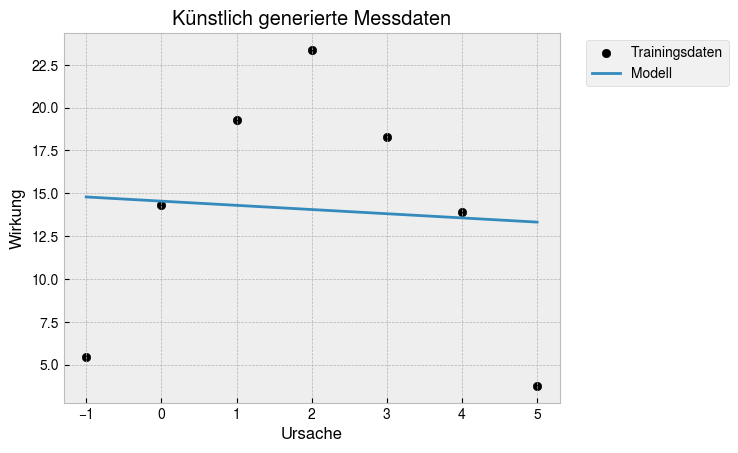

In [18]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# styling of plots
plt.style.use('bmh')

# artificial data: f(x) = −2𝑥^2 + 8𝑥 + 15 + error
X = np.array([-1, 0, 1, 2, 3, 4, 5]).reshape(-1,1)
y = np.array([5.4384, 14.3252, 19.2451, 23.3703, 18.2885, 13.8978, 3.7586])

# preprocessing and training linear regression
model = LinearRegression()
model.fit(X, y)
print('R2-score Trainingsdaten: {:.2f}'.format(model.score(X, y)))

# prediction
X_prediction = np.linspace(-1, 5).reshape(-1,1)
y_prediction = model.predict(X_prediction)

# visualization
fig, ax = plt.subplots()
ax.scatter(X, y, color='k', label='Trainingsdaten')
ax.plot(X_prediction, y_prediction, label='Modell')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');

Schon die Visualisierung zeigt, dass lineare Regression bei diesen Daten keine
gute Idee ist. Der R²-Score ist auch bei 0.

Außer der linearen Modellfunktion gibt es ja noch Polynome höheren Grades, also
quadratische Funktion oder kubische Funktionen. Wenn Sie in der Dokumentation
von Scikit-Learn nun nach einer Funktion zur polynomialen Regression suchen,
werden Sie nicht fündig werden. Tatsächlich brauchen wir auch keine
eigenständige Funktion, sondern können uns mit einem Trick weiterhelfen. 

Das lineare Regressionsmodell, das wir eben ausprobiert haben, lautet
mathematisch formuliert folgendermaßen:

$$y^{(i)} = \omega_0 + \omega_1 \cdot x^{(i)}$$

mit nur einem Input $x$.

Wenn wir eine quadratische Funktion als Modellfunktion wählen möchten, erzeugen
wir einfach eine zweite Eigenschaft. Wir nennen die bisherigen x-Werte $x^{(i)}$ jetzt $x_1^{(i)}$ und fügen als zweiten Input die neue Eigenschaft

$$x_2^{(i)} = \left( x_1^{(i)} \right)^2$$

hinzu.  

Dieser Trick wird auch bei anderen ML-Verfahren angewandt. Aus einem Input, aus
einer Eigenschaft werden jetzt eine neue Eigenschaften erzeugt. Aus einem
eindimensionalen Input wird ein zweidimensionaler Input. Mathematisch gesehen
haben wir die Input-Daten in einen höherdimensionalen Bereich projiziert. Diese
Methode nennt man **Kernel-Trick**. Es ist auch möglich, andere Funktionen zu
benutzen, um die Daten in einen höherdimensionalen Raum zu projizieren, z.B.
radiale Gaußsche Basisfunktionen. Das nennt man dann **Kernel-Methoden**.  

In dieser Vorlesung bleiben wir aber bei den Polynomen als Basisfunktion.
Scikit-Learn stellt auch hier passende Methoden bereit, siehe [Dokumentation
Scikit-Learn →
PolynomialFeature](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).
Wir erzeugen das PolynomialFeature-Objekt mit der Option `degree=2`, um die
Quadrate hinzuzufügen. Dann transformieren wir die Input-Daten, indem wir die
`fit_transform()`-Methode auf den Input anwenden.
 


In [19]:
from sklearn.preprocessing import PolynomialFeatures

print('Original X:\n', X)

# lade die Polynom-Transformator 
polynom_transformator = PolynomialFeatures(degree = 2)

# transformiere X
X_transformiert =  polynom_transformator.fit_transform(X)
print('transformiertes X:\n', X_transformiert)

Original X:
 [[-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]]
transformiertes X:
 [[ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]]


Aus dem Spaltenvektor macht Scikit-Learn eine Matrix, bei der in der 1. Spalte nur Einsen stehen, die 2. Spalte enthält die ursprünglichen x-Werte und die 3. Spalte nun die Quadrate der ursprünglichen x-Werte.

Damit können wir nun ein multiples lineares Regressionsmodell trainieren, also die
Koeffizienten suchen, so dass 

$$y^{(i)} = \omega_0 + \omega_1 \cdot x_1^{(i)} + \omega_2 \cdot x_2^{(i)}$$ 

mit möglichst kleinen Fehlern gilt. Hier der komplette Code inklusive Visualisierung:

R2-score Trainingsdaten: 0.98


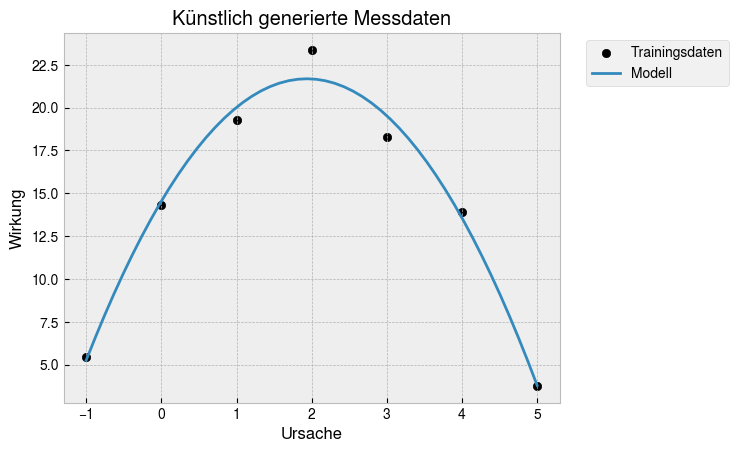

In [20]:
# project data
X2 = PolynomialFeatures(degree = 2).fit_transform(X)

# preprocessing and training linear regression
model = LinearRegression()
model.fit(X2, y)
print('R2-score Trainingsdaten: {:.2f}'.format(model.score(X2, y)))

# prediction
X_prediction = PolynomialFeatures(degree = 2).fit_transform(np.linspace(-1, 5).reshape(-1,1))
y_prediction = model.predict(X_prediction)

# visualization
fig, ax = plt.subplots()
ax.scatter(X2[:,1], y, color='k', label='Trainingsdaten')
ax.plot(X_prediction[:,1], y_prediction, label='Modell')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');

Wäre eine kubische Modellfunktion noch besser? Wir fügen noch eine dritte Eigenschaft hinzu, nämlich

$$x_3^{(i)} = \left( x_1^{(i)} \right)^{3}.$$

Natürlich lassen wir auch hier Scikit-Learn für uns arbeiten und sezten die Option `degree` diesmal auf den Wert 3.

R2-score Trainingsdaten: 0.98


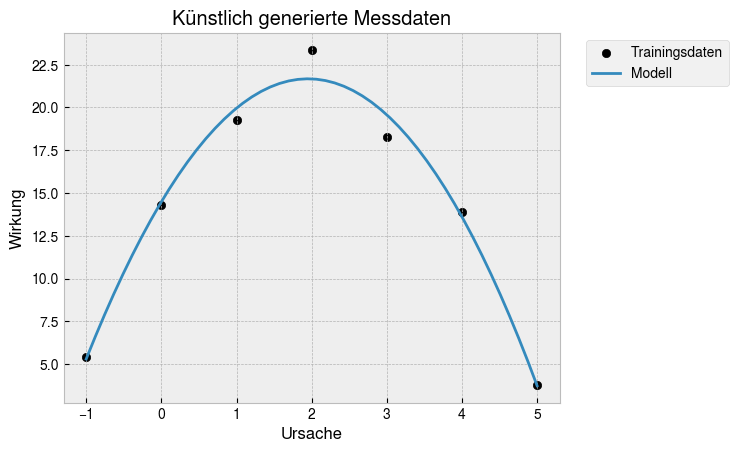

In [21]:
# project data
X3 = PolynomialFeatures(degree = 3).fit_transform(X)

# preprocessing and training linear regression
model = LinearRegression()
model.fit(X3, y)
print('R2-score Trainingsdaten: {:.2f}'.format(model.score(X3, y)))

# prediction
X_prediction = PolynomialFeatures(degree = 3).fit_transform(np.linspace(-1, 5).reshape(-1,1))
y_prediction = model.predict(X_prediction)

# visualization
fig, ax = plt.subplots()
ax.scatter(X3[:,1], y, color='k', label='Trainingsdaten')
ax.plot(X_prediction[:,1], y_prediction, label='Modell')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');

Könnte tatsächlich besser sein. Und ist vielleicht ein Polynom 4. Grades noch
besser? Wir betrachten den Polynomgrad als Hyperparameter des Modells
"Regressionspolynom" und gehen einfach mal alle Regressionspolynome bis Grad 7
durch.

R2-score für Grad 4: 0.984687480835
R2-score für Grad 5: 0.985549560915
R2-score für Grad 6: 1.000000000000
R2-score für Grad 7: 1.000000000000


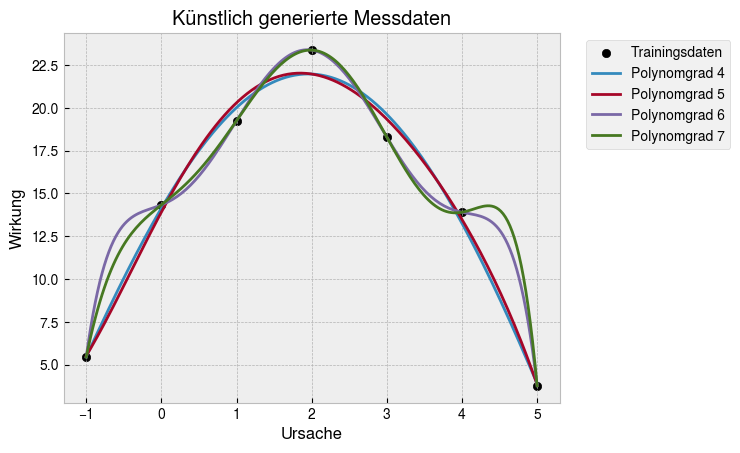

In [22]:

model = LinearRegression()

# visualization
fig, ax = plt.subplots()
ax.scatter(X, y, color='k', label='Trainingsdaten')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')

for d in range(4,8):
    X_transformiert = PolynomialFeatures(degree = d).fit_transform(X)
    model.fit(X_transformiert, y)
    print('R2-score für Grad {0}: {1:.12f}'.format(d, model.score(X_transformiert, y)))

    # prediction
    X_prediction = PolynomialFeatures(degree = d).fit_transform(np.linspace(-1, 5, 200).reshape(-1,1))
    y_prediction = model.predict(X_prediction)

    label_string = 'Polynomgrad {}'.format(d)
    ax.plot(X_prediction[:,1], y_prediction, label=label_string)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');



Ab Grad 6 kann keine Verbesserung des R²-Scores mehr erzielt werden (warum?).
Auch scheinen die Polynom mit Grad 6 und Grad 7 in den Intervallen $[-1,0]$ und
$[4,5]$ etwas schwankend. Vielleicht müssen wir doch noch höher gehen. Schauen
wir uns Grad 8 an:

R2-score für Grad 8: 1.000000


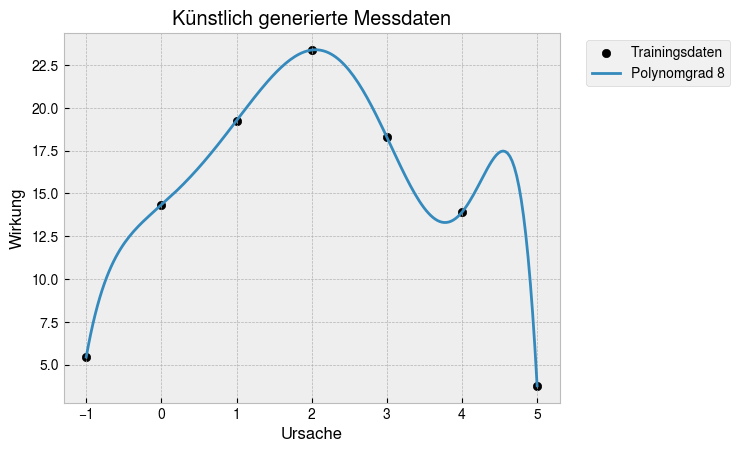

In [23]:
# visualization
fig, ax = plt.subplots()
ax.scatter(X, y, color='k', label='Trainingsdaten')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')

d = 8
X_transformiert = PolynomialFeatures(degree = d).fit_transform(X)
model.fit(X_transformiert, y)
print('R2-score für Grad {0}: {1:.6f}'.format(d, model.score(X_transformiert, y)))

# prediction
X_prediction = PolynomialFeatures(degree = d).fit_transform(np.linspace(-1, 5, 200).reshape(-1,1))
y_prediction = model.predict(X_prediction)

label_string = 'Polynomgrad {}'.format(d)
ax.plot(X_prediction[:,1], y_prediction, label=label_string)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');

Tatsächlich werden dadurch die Schwankungen im Intervall $[4,5]$ noch verstärkt.
Für Grad 9 wird es noch schlimmer, doch diesmal geht es in die andere Richtung.

R2-score für Grad 9: 1.000000


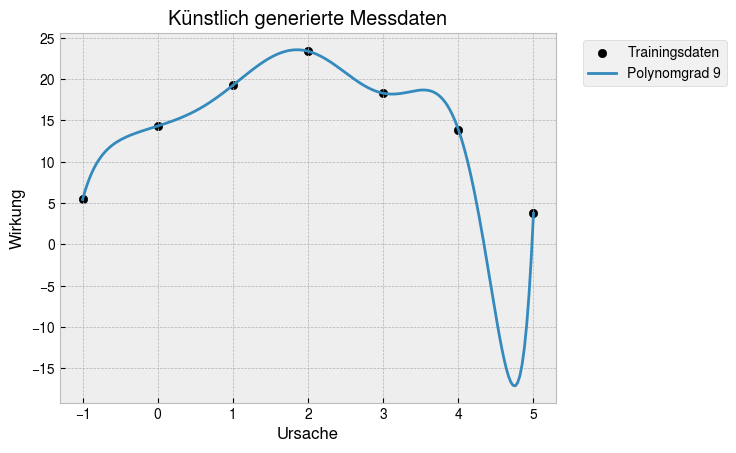

In [25]:
# visualization
fig, ax = plt.subplots()
ax.scatter(X, y, color='k', label='Trainingsdaten')
ax.set_xlabel('Ursache')
ax.set_ylabel('Wirkung')
ax.set_title('Künstlich generierte Messdaten')

d = 9
X_transformiert = PolynomialFeatures(degree = d).fit_transform(X)
model.fit(X_transformiert, y)
print('R2-score für Grad {0}: {1:.6f}'.format(d, model.score(X_transformiert, y)))

# prediction
X_prediction = PolynomialFeatures(degree = d).fit_transform(np.linspace(-1, 5, 200).reshape(-1,1))
y_prediction = model.predict(X_prediction)

label_string = 'Polynomgrad {}'.format(d)
ax.plot(X_prediction[:,1], y_prediction, label=label_string)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left');

Die Regression mit Polynomen unerschiedlichen Grades verdeutlicht das sogenannte
**Bias-Varianz-Dilemma**. Das lineare Regressionsmodell hat zwei Parameter,
Steigung und y-Achsenabschnitt. Scheinbar sind das zuwenige Modellparameter, um
die Messdaten gut zu erklären und zu prognostizieren. Wir sind sozusagen mit dem
Vorurteil in unsere Modellierung gestartet, dass diese zwei Modellparameter
ausreichen werden, um die Daten gut zu erklären. In der ML-Community sagt man,
dass ein großer **Bias** vorliegt. Das Modell ist zu wenig an die Daten
angepasst oder anders ausgedrückt, es liegt eine Unteranpassung an die Daten
vor. Dafür ist auch in der deutschsprachigen Literatur das englische Wort
**Underfitting** sehr gebräuchlich.

Bei dem Polynom mit Grad 9 haben wir 10 Modellparameter. Offensichtlich sind
das zuviele Parameter (es liegen ja nur sieben Messwerte vor). Die **Varianz**
ist zu groß. Bereits bei der gefundenen Modellfunktion beobachten wir große
Schwankungen, insbesondere im Intervall [4,5]. Aber auch durch die Hinzunahme
eines einzigen Datenpunktes würden wir eine komplett andere Modellfunktion
erhalten. Das Modell reagiert sehr sensibel selbst auf kleine Änderungen. Das
nennen wir Überanpassung oder **Overfitting**. 

Bei der Modellwahl stehen wir stets vor dem Dilemma, ein Modell mit zu wenigen
Parametern oder eines mit zu vielen Parametern zu wählen. 

## Mit Validierungskurven Modell wählen

Wenn wir in der glücklichen Situation sind, die Komplexität des Modells wählen
zu können, hilft uns eine Analyse der sogenannten **Validierungskurven** weiter, um
dem Bias-Varianz-Dilemma zu begegnen.

Dazu starten wir bei dem einfachsten Modell (hier in unserem Beispiel mit
Polynomgrad 1) und berechnen den R²-Score sowohl für die Test- als auch die
Trainingsdaten. Wenn das Modell zu einfach ist, werden beide Scores schlecht
ausfallen. Da wir das Modell mit den Trainingsdaten trainieren, sollte jedoch
der R²-Score für die Trainingsdaten besser sein als für die Testdaten.

Nehmen wir mehr Modellparameter hinzu, sollten sich sowohl der Score für die
Trainingsdaten als auch der Score für die Testdaten verbessern. Je mehr
Modellparameter hinzukommen, desto besser wird der Score für die Trainingsdaten,
bis es irgendwann einfach nicht mehr besser geht. Bei unseren künstlich
generierten Daten haben wir bereits ab Polynomgrad 6 keine Verbesserung mehr
gesehen. Der R²-Score lag ab da bei 1.

Anders hingegen verhält es sich bei dem Score der Testdaten. Würden wir
beispielsweise unser Modell mit Polynomgrad 9 im Intervall $[4,5]$ auswerten, so
würden negative Werte prognostiziert werden. Da wir hier mit künstlich erzeugten
Daten arbeiten, wissen wir aber, dass diese mit einer quadratischen Funktion
erzeugt wurden und in diesem Bereich positiv sein müssen. Wir hätten daher einen
großen Fehler und einen schlechten R²-Score für die Testdaten.  

Wenn wir nun den Score (das gilt nicht nur für den R²-Score, sondern auch für
andere Bewertungskriterien, die wir noch kennenlernen werden) abhängig von der
Komplexität eines Modells auftragen, nennen wir die entstehende Kurve
**Validierungskurve**. Prinzipiell sehen die Validierungskurve für die
Trainings- und Testdaten folgendermaßen aus:

```{figure} pics/validierungskurven_annotated.pdf
---
width: 600px
name: fig_validierungskurven
---
Schematische Darstellung von typischen Validierungskurven der Test- und Trainingsdaten zur Wahl der geeigneten Modellkomplexität
```

## Zusammenfassung 

In diesem Abschnitt haben wir das Bias-Varianz-Dilemma kennengelernt, das vor
allem bei der Auswahl eines geeigneten Modells auftritt. Wir haben auch gesehen,
wie prinzipiell anhand von Validierungskurven bewertet werden kann, ob das
Modell Overfitting oder Underfitting zeigt.